In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 26 11:38:22 2022

@author: lau
"""

#%% IMPORTS

import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

In [16]:
#%% PREPROCESSING FUNCTIONS

def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40, # high pass filter
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4): # decima = downsampling the data. 4 = 1000Hz -> 250Hz. The higher, the more downsampling.
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    epochs_list = list()
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif')
        print(full_path)
        raw = mne.io.read_raw(full_path, preload=True)
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3)
        
        events = mne.find_events(raw, min_duration=0.002)
        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12,
                            button_press=23)
        elif 'other' in recording_name: 
            event_id = dict(other_positive=21, other_negative=22,
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim)
        epochs.pick_types(meg=True)
        
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list

# gives the X data that we need for classification
def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
        
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        
        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))
            
    return X, y

In [17]:
#%% RUNNING FUNCTIONS
rawpath = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG"
subjects_dir = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482"

epochs_list = preprocess_sensor_space_data('0111', '20230926_000000',
        raw_path= rawpath,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list) # shape= 720, 306, 121: 720 trials, 306 sensors, 121 time points (121 time points because of decim=10)

/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 430000 ... 811999 =    430.000 ...   811.999 secs
Ready.
Reading 0 ... 381999  =      0.000 ...   381.999 secs...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.1s finished


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 151000 ... 528999 =    151.000 ...   528.99

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.8s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.6s finished
/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-R

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.8s finished


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 51000 ... 429999 =     51.000 ...   429.999

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.9s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.8s finished


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 39000 ... 415999 =     39.000 ...   415.999 sec

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.9s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.6s finished


161 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 50000 ... 425999 =     50.000 ...   425.999

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.9s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.7s finished


160 events found
Event IDs: [ 21  22  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [13]:
#%% RUNNING FUNCTIONS

rawpath = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG"
subjects_dir = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482"

epochs_list = preprocess_sensor_space_data('0111', '20230926_000000',
        raw_path= rawpath,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list) # shape= 720, 306, 121: 720 trials, 306 sensors, 121 time points (121 time points because of decim=10)

# reads the sensor space data and do source reconstruction of each the trials. 
X_source, y = preprocess_source_space_data('0111', '20230926_000000',
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        epochs_list=epochs_list) ##CHANGE TO YOUR PATHS

X_lh_BA44, y = preprocess_source_space_data('0111', '20230926_000000',
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.BA44_exvivo.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.
        ##CHANGE TO YOUR PATHS
        
        
X_lh_V1, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.V1_exvivo.label', epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS        

/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 430000 ... 811999 =    430.000 ...   811.999 secs
Ready.
Reading 0 ... 381999  =      0.000 ...   381.999 secs...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  51 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.8s finished


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 151000 ... 528999 =    151.000 ...   528.99

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.9s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed: 15.2min finished


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 71000 ... 448999 =     71.000 ...   448.999 sec

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:  1.9min finished


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 51000 ... 429999 =     51.000 ...   429.999

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 300 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.0s finished


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 39000 ... 415999 =     39.000 ...   415.999 sec

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 303 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.1s finished


161 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 50000 ... 425999 =     50.000 ...   425.999

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:16: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 297 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.2s finished


160 events found
Event IDs: [ 21  22  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_46895/4199967518.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 2.6e-09 (2.2e-16 eps * 306 dim * 3.9e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created

In [18]:
#%% SIMPLE CLASSIFICATION

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


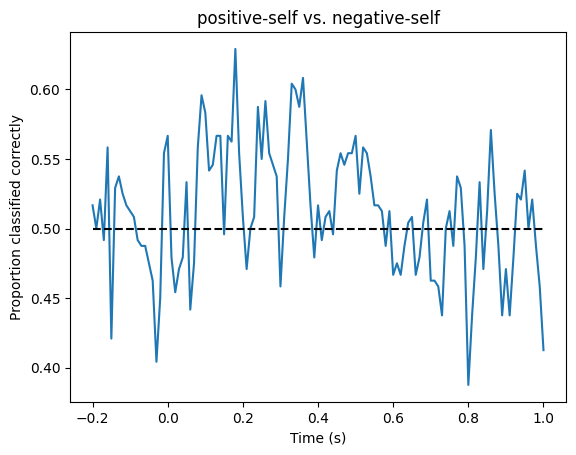

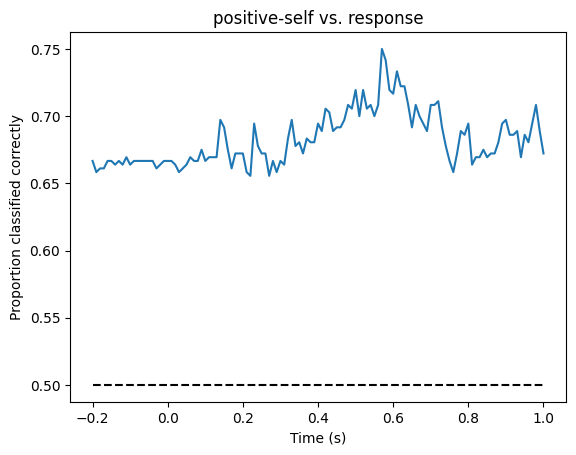

In [19]:
#%% RUN FUNCTION


sensor_pos_neg_self = simple_classication(X_sensor,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response = simple_classication(X_sensor,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

    
#%% PLOT


    
plot_classfication(times, sensor_pos_neg_self,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response,
                   title='positive-self vs. response')

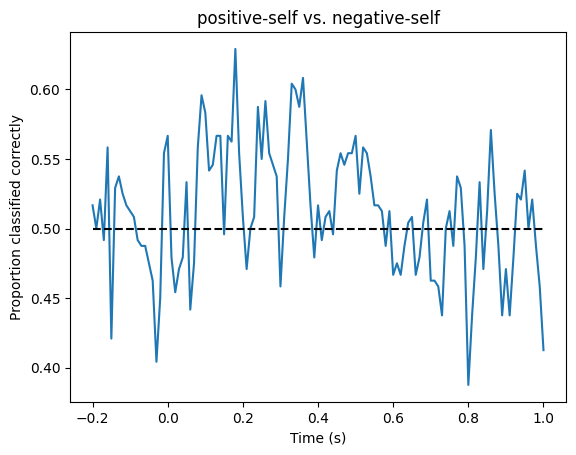

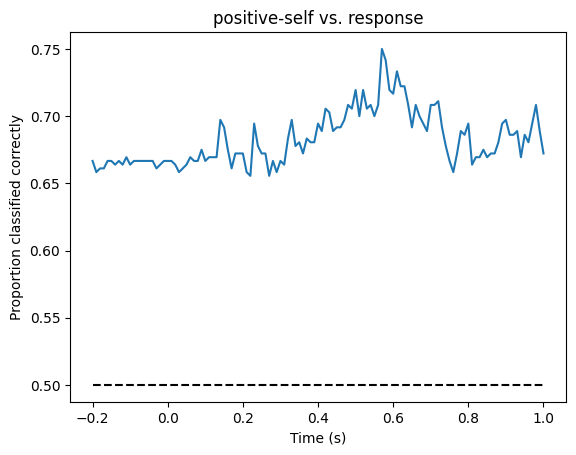

In [9]:
#%% PLOT
plot_classfication(times, sensor_pos_neg_self,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response,
                   title='positive-self vs. response')